In [17]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [18]:
import sys
sys.path.insert(0, '../')  # Adjust the path as necessary


In [19]:
import cvaei
import torch
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

from cvaei.models.cvae_inference import CVAE
from cvaei.helper import DataNormalizer
from cvaei.visualize import scatter_plot_ma2
from cvaei.examples.MA2 import MovingAverage2
from cvaei.examples.two_moons import TwoMoons

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



Using device: cpu
False
None


In [20]:
two_moons = TwoMoons()
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer = two_moons.prepare_data(100000)
observed_data = two_moons.observed_data()
print(two_moons.check_normalizer())

Normalization and denormalization process is consistent for both parameters and observed data.
None


# Initialise the Model

In [21]:
# ma2 = MovingAverage2()
# train_theta_norm, train_data_norm, theta_normalizer, data_normalizer = ma2.prepare_data(1000)
# observed_data = ma2.observed_data()
# print(ma2.check_normalizer())

test = torch.tensor([0.4409, 0.5635], dtype = torch.float32)
two_moons.simulator(test)

tensor([-0.4264,  0.1740])

In [22]:
two_moons.simulator(test)

tensor([-0.4264,  0.1740])

In [23]:
two_moons.simulator(test)

tensor([-0.4264,  0.1740])

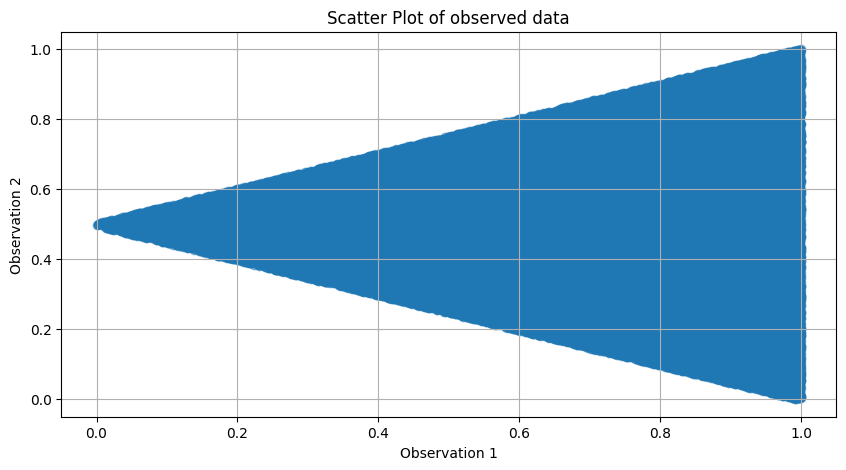

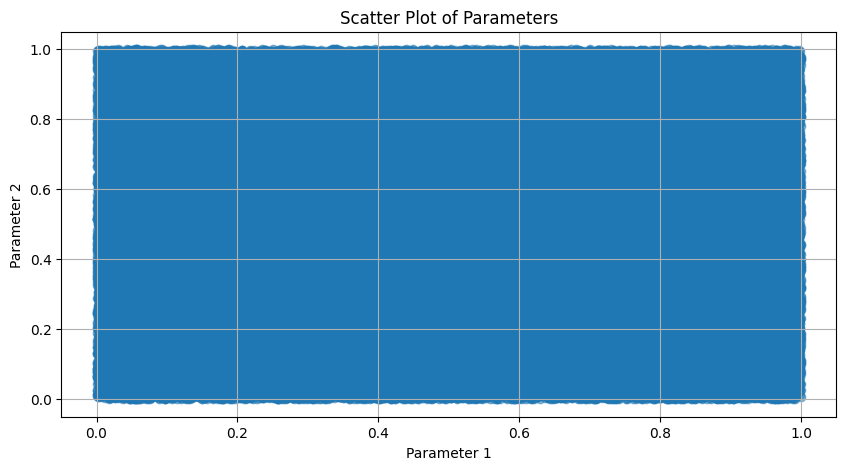

In [24]:
two_moons.plot_observation(train_data_norm)
two_moons.plot_prior(train_theta_norm)

# Define the CVAE Network

In [25]:
input_dim = 2
latent_dim = 40
conditional_dim = 2
encoder_hidden_dims = [200, 200]
decoder_hidden_dims = [200,200]


network = CVAE(input_dim=input_dim, latent_dim=latent_dim, output_dim=input_dim,
        conditional_dim=conditional_dim, encoder_hidden_dims=encoder_hidden_dims,
        decoder_hidden_dims=decoder_hidden_dims)


optimizer = optim.AdamW(network.parameters(), lr=1e-3)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)

#print(network)

In [26]:
network.train_model(train_loader=train_loader, optimizer=optimizer, epochs=5, 
                    device=device, theta_normalizer=theta_normalizer,
                      data_normalizer=data_normalizer, forward_model= two_moons.simulator)

Using CPU
Epoch 1/5, Beta: 0.0, Total Loss: 12029.2116, Recon Loss: 6333.1939, Misfit Loss: 5696.0175, KL Div: 2387640.8488
Epoch 2/5, Beta: 0.1, Total Loss: 53847.7428, Recon Loss: 9706.3610, Misfit Loss: 11596.4958, KL Div: 325448.8559
Epoch 3/5, Beta: 0.2, Total Loss: 19999.1455, Recon Loss: 7468.0381, Misfit Loss: 11593.7661, KL Div: 4686.7068
Epoch 4/5, Beta: 0.3, Total Loss: 18210.4463, Recon Loss: 6588.0332, Misfit Loss: 10514.5795, KL Div: 3692.7787
Epoch 5/5, Beta: 0.4, Total Loss: 12853.8007, Recon Loss: 4181.4986, Misfit Loss: 6973.0826, KL Div: 4248.0485


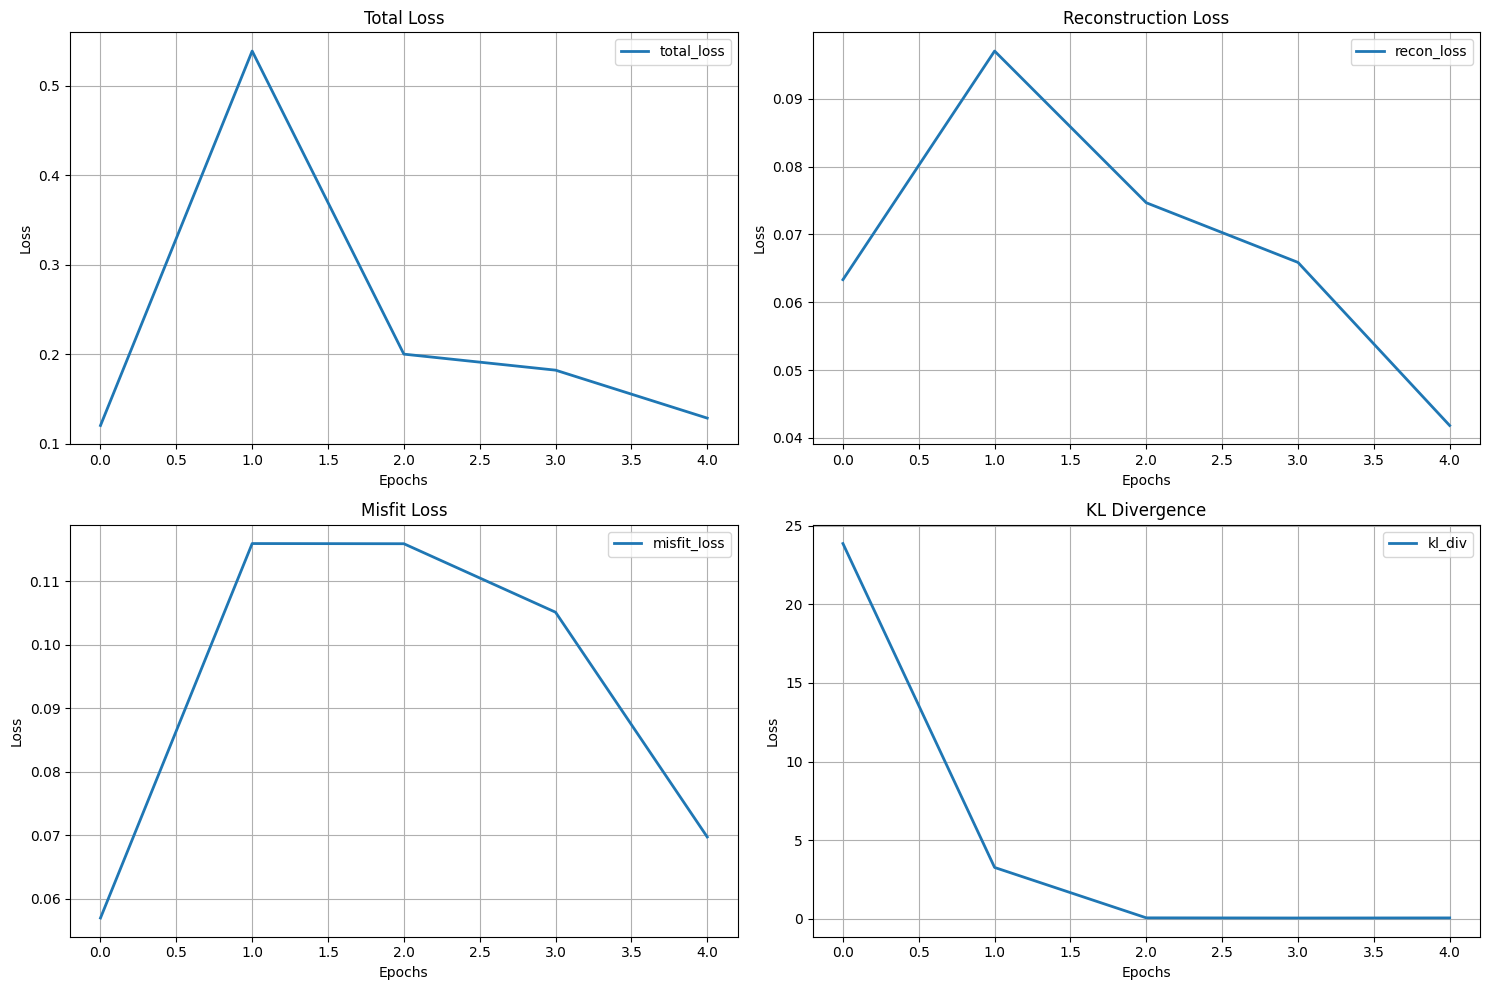

In [27]:
network.plot_loss()

# Inference

In [28]:
post = network.get_posterior(observed_data= observed_data, num_samples=10000)
post = theta_normalizer.inverse_transform(post)


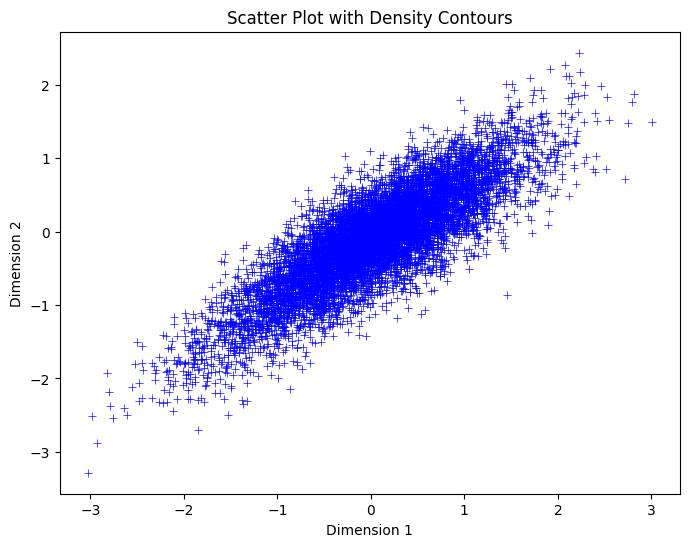

In [29]:
two_moons.plot_posterior(post)

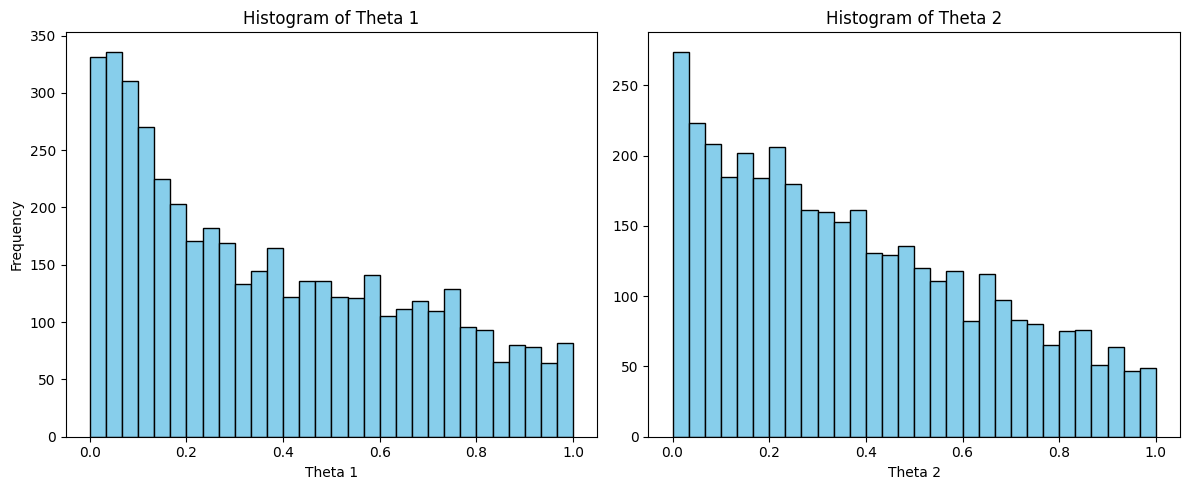

In [30]:
two_moons.posterior_hist(post)

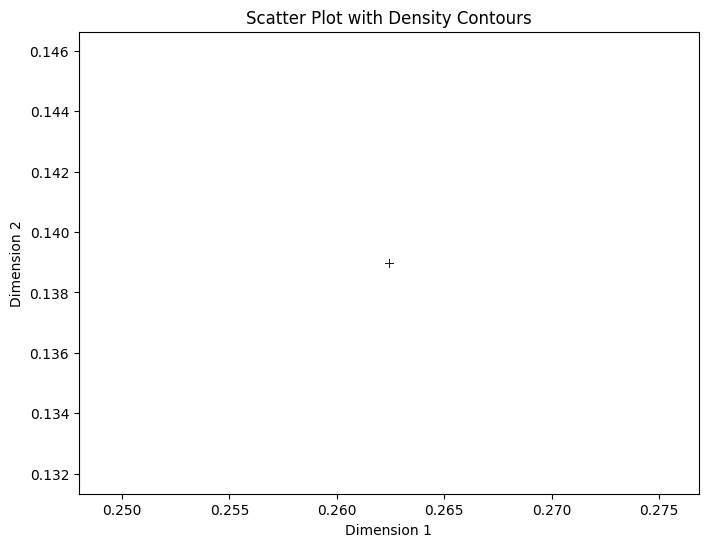

In [31]:
two_moons.analytic_posterior()